## Unsupervised machine learning: K-Means clustering, hierarchical clustering - dendrogram? PCA?

To do list:
1. Reduce variance by standardising
2. check for correlations
3. try different values of k: the 'elbow' of the intertia plot, silhouette score? Try loop of k values
4. create a pipeline with different scalers, and k values?

Need to add more

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats

# import unsupervised ML submodules
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, make_scorer, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
# load dataset
df1 = pd.read_csv('Country-data.csv')

# inspect dataset
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [4]:
# describe, info, heatmap, deal with missing values, make numeric, outliers, reduce variance, train/test split?
# inspect dataset further
df1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## To do list:
1. visualise for missing and outlier values, deal with them
2. check duplicates? Nulls as 0s?
3. Check correlation with heatmap, reduce correlation with PCA later
3. temp remove country column, as not contributing to clustering decision
4. train/evalute split

### Pipeline:
1. scale data
2. PCA
3. try out different models

### After pipeline:
1. After, add country labels back in to see
2. Visualise country clusters on a map using GeoPandas?
3. Make a cross-tabulation with actual recipients of aid, or UN classifications (middle income, least developed etc.)

In [5]:
# store countries column for later
countries_col = df1['country']

# drop countries column as it does not contribute to clustering decision
df2 = df1.drop('country', axis=1)

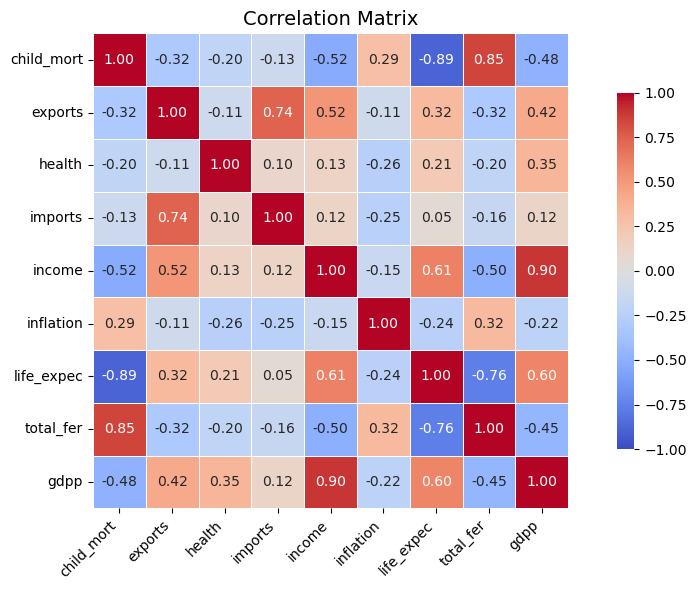

In [6]:
# create and examine correlation matrix
correlation_matrix = df2.corr()

# create heatmap of correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})

# add title and labels
plt.title('Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

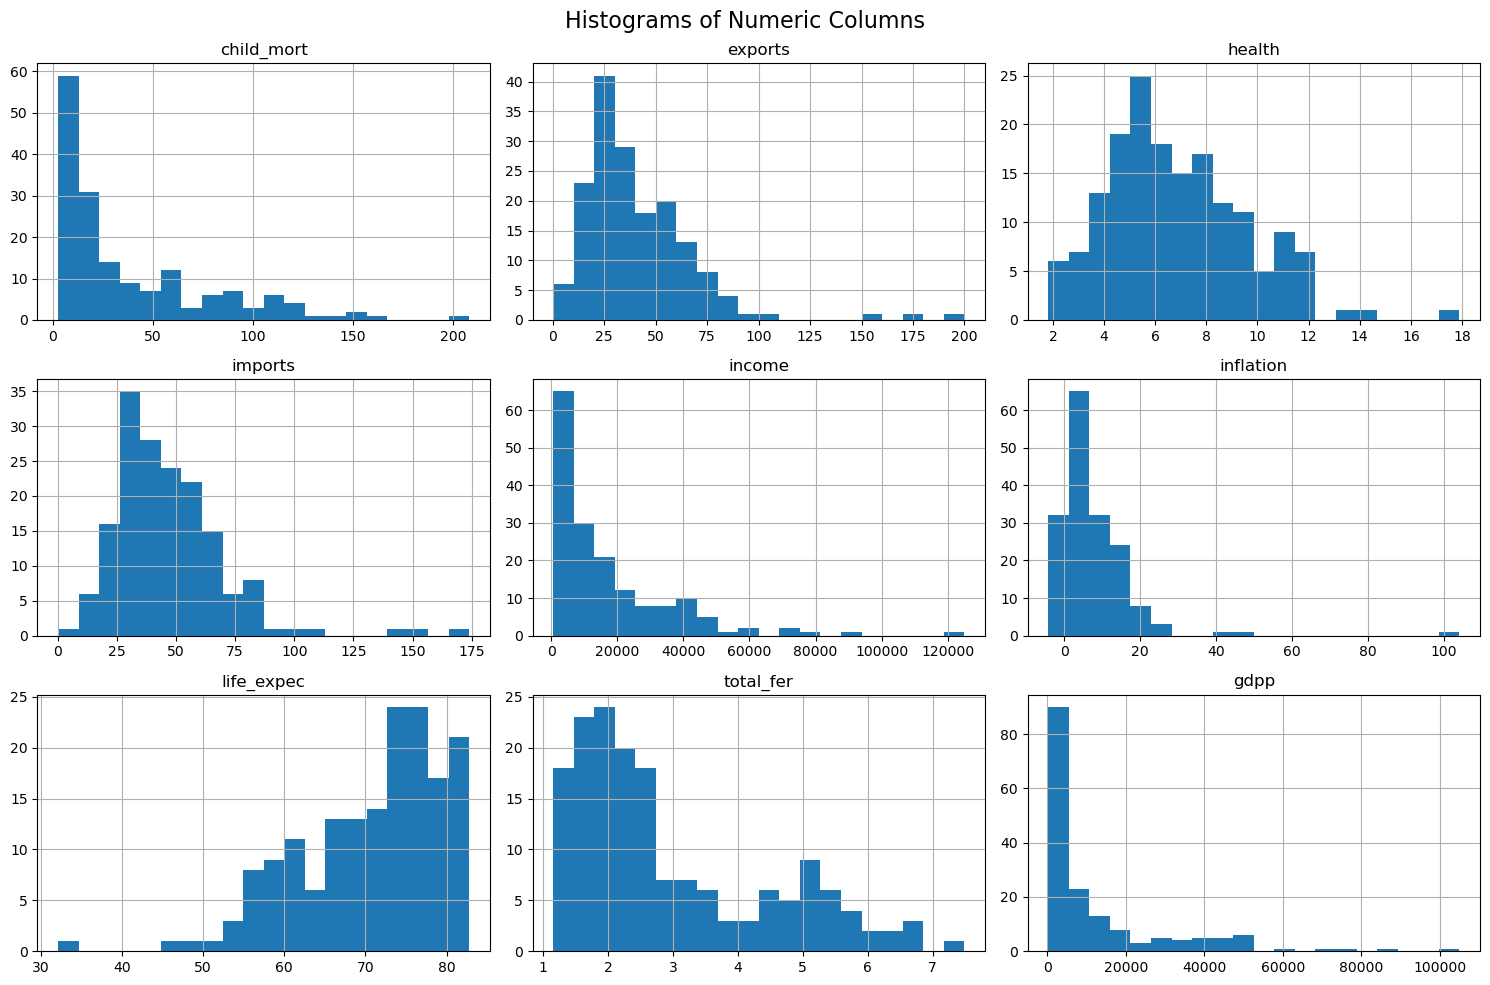

In [7]:
# visualise distribution of columns
df2.hist(bins=20, figsize=(15, 10))

plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
"""No missing values: no nulls or nonsensical zeros. Lots of outliers in every column and uneven skew.
   Only 168 rows, so don't want to remove outliers. Feature clip to re-scale outliers and reduce skewedness"""

# define lists: column buckets to clip
right_skew_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'total_fer','gdpp']

# feature clip right-skewed cols to remove outliers and reduce skewedness
for col in right_skew_cols:
    lower = df2[col].quantile(0.00)
    upper = df2[col].quantile(0.95)
    df2[col] = df2[col].clip(lower=lower, upper=upper)

# feature clip life_expectancy column, which is left-skewed
df2['life_expec'] = df2['life_expec'].clip(lower=df2['life_expec'].quantile(0.05),
                                                 upper=df2['life_expec'].quantile(1))

/tmp/ipykernel_74757/2434810266.py:11: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2[col] = df2[col].clip(lower=lower, upper=upper)


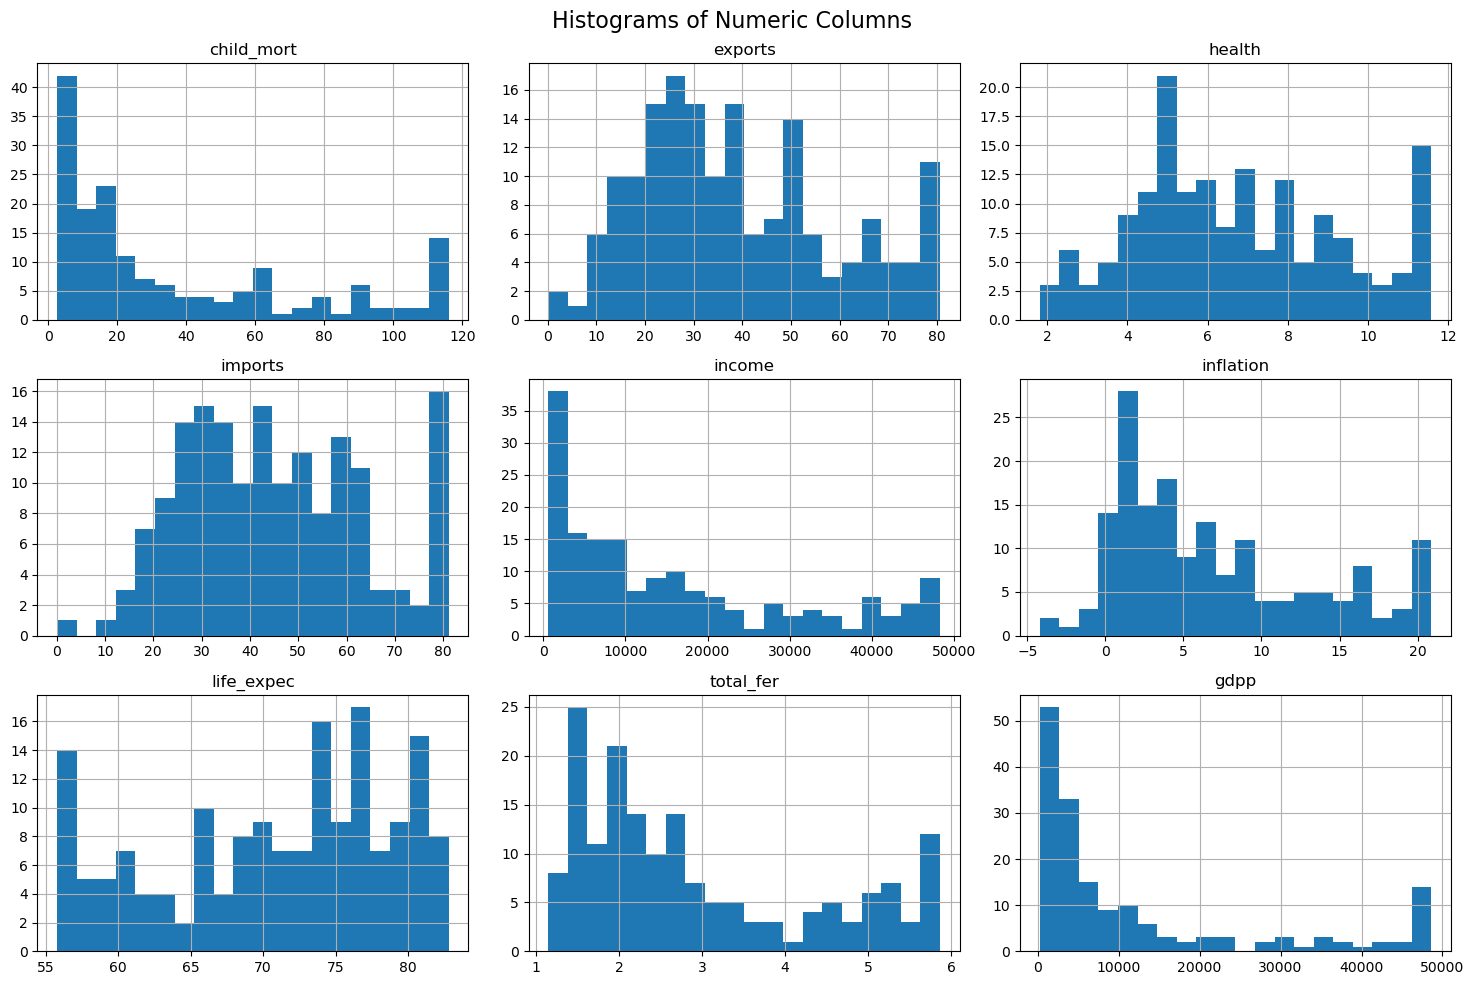

In [9]:
# visualise distribution of clipped columns
df2.hist(bins=20, figsize=(15, 10))

plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

### Pipeline
scale: Standard,Robust,MinMaxScaler and Powertransformer
reduce dimensionality: PCA, t-SNE
model selection: K-Means, hierarchical clustering, DBSCAN
evaluation metrics: Silhouette score, Davies Bouldin index
visualise results on scatterplot

### Post-pipeline
Add in countries column again to compare
Cross-tabulation with real world dataset
Visualise countries on a map using GeoPandas

In [10]:
# split the data into training and evaluation sets
X_train, X_eval = train_test_split(df2, test_size=0.2, random_state=42)

In [ ]:
# define our pipeline format
cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA()),
    ('cluster', KMeans())
])

# define scalers list
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), PowerTransformer()]
dimension_reducers = [PCA(n_components=2), 'passthrough']

# define our parameter grid
param_grid = [
    {'scaler': scalers,
    'reduce_dim': dimension_reducers,
    'cluster': [KMeans()],
    'cluster__n_clusters': [2, 3, 4, 5, 6, 7, 8]
    },
    {'scaler': scalers,
    'reduce_dim': dimension_reducers,
    'cluster': [AgglomerativeClustering()],
    'cluster__n_clusters': [2, 3, 4, 5, 6, 7, 8],
    'cluster__linkage': ['ward', 'complete', 'average']
    },
    {'scaler': scalers,
    'reduce_dim': dimension_reducers,
    'cluster': [DBSCAN()],
    'cluster__eps': [0.3, 0.5, 0.7],
    'cluster__min_samples': [3, 5, 7]
    },
]

# Now use the custom scorer in GridSearchCV
grid_search = GridSearchCV(cluster_pipeline, param_grid, scoring=silhouette_score, cv=5, n_jobs=-1)
grid_search.fit(X_train, y=None)


print("Best parameters:", grid_search.best_params_)
print("Best silhouette score:", grid_search.best_score_)